# Project

Herman Autore

This is based on `scikit-survival`'s [introduction noteboook](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb).

## The Data

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import AalenJohansenFitter, KaplanMeierFitter
from sksurv.compare import compare_survival
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.nonparametric import kaplan_meier_estimator

data_x, data_y = load_veterans_lung_cancer()

Entire response variable

In [28]:
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

Subset of response variable

In [27]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


## Unstratified survival function

Text(0.5, 0, 'time $t$')

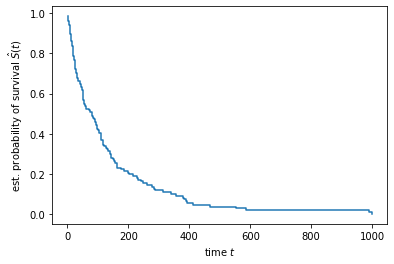

In [4]:
time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Survival function by treatment type

In [5]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

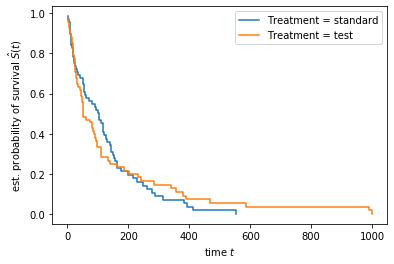

In [6]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

_Visually comparing estimated survival curves in order to assess whether there is a difference in survival between groups is usually not recommended, because it is highly subjective. Statistical tests such as the [log-rank test](https://en.wikipedia.org/wiki/Log-rank_test) are usually more appropriate._

## Compare survival functions using log-rank test

In [12]:
chisq, pvalue, stats, cov = compare_survival(data_y, data_x["Treatment"], return_stats=True)

In [13]:
chisq

0.008227343202350305

In [14]:
pvalue

0.9277272333400758

In [15]:
stats

,counts,observed,expected,statistic
group,,,,
standard,69,64,64.500197,-0.500197
test,68,64,63.499803,0.500197


We see from the results that the treatment and control groups are not different.

## Survival function by cell type

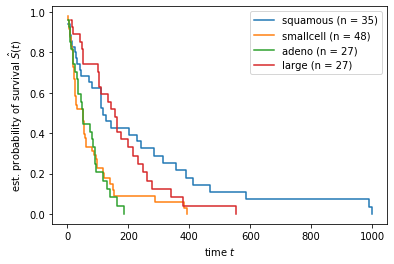

In [16]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [8]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [17]:
chisq, pvalue, stats, cov = compare_survival(data_y, data_x["Celltype"], return_stats=True)

In [18]:
chisq

25.40370034578536

In [19]:
pvalue

1.271245939006091e-05

In [20]:
stats

,counts,observed,expected,statistic
group,,,,
adeno,27,26,15.693765,10.306235
large,27,26,34.549478,-8.549478
smallcell,48,45,30.102079,14.897921
squamous,35,31,47.654678,-16.654678


## Competing Risk Analysis

I'm not sure if `scikit-survival` has a competing risk algorithm, but there are several ways to do competing risk estimates:

1. The `lifelines` package in Python
2. The `cmprsk` package in R


In [23]:
df = pd.DataFrame()
df['events'] = [0, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2]
df['times'] = [1, 5, 3, 6, 1, 3, 2, 5, 2, 3, 6]
aj = AalenJohansenFitter()
aj.fit(durations=df['times'], event_observed=df['events'], event_of_interest=1)
print(aj.cumulative_density_)

             CIF_1
event_at          
0.000000  0.000000
0.999952  0.000000
1.000000  0.000000
2.000000  0.000000
2.999931  0.129870
2.999945  0.259740
3.000097  0.259740
4.999957  0.389610
5.000072  0.519481
6.000016  0.649351
6.000042  0.649351


/Users/herman/Library/Python/3.7/lib/python/site-packages/lifelines/fitters/aalen_johansen_fitter.py:116: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  Warning,


### Modify data to a `lifelines`-compatible format

In [77]:
celltypes = data_x['Celltype']
n = len(celltypes)
censored_cases = [x for x,y in data_y]
jitter = np.random.normal(0, 0.001, n)
survival_times = [y for x,y in data_y] + jitter
event_of_interest = 'squamous' # 'squamous', 'smallcell', 'adeno', 'large'

In [78]:
# Replace celltypes with integers >= 1
observed_events = data_x['Celltype'].to_numpy()
i = 1
eventMap = {}
for celltype in data_x['Celltype'].unique():
    mask = observed_events == celltype
    observed_events[mask] = i
    eventMap[celltype] = i
    i += 1

event_of_interest = eventMap[event_of_interest]

# Replace celltypes with 0 if that case was censored
indexForCensored = np.argwhere( censored_cases == False)
observed_events[ indexForCensored ] = 0
observed_events = observed_events.tolist()

In [79]:
km = KaplanMeierFitter()
km.fit(durations = survival_times,
       event_observed = observed_events)

aj = AalenJohansenFitter()
aj.fit(durations = survival_times,
       event_observed = observed_events,
       event_of_interest = event_of_interest)

results = pd.DataFrame()
results['timeline'] = km.cumulative_density_.index
results['km curve'] = km.cumulative_density_['KM_estimate'].values
results['aj CIF'] = np.array(aj.cumulative_density_)
print(results)

       timeline  km curve    aj CIF
0      0.000000  0.000000  0.000000
1      1.000464  0.007299  0.007299
2      1.000581  0.014599  0.014599
3      1.999074  0.021898  0.014599
4      2.999273  0.029197  0.014599
..          ...       ...       ...
133  467.000974  0.970803  0.233577
134  552.999885  0.978102  0.233577
135  586.998774  0.985401  0.240876
136  990.999701  0.992701  0.248175
137  999.001263  1.000000  0.255474

[138 rows x 3 columns]


In [ ]:
# Do this for each cell and compare CIF. See .py file